In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import optim
from torch.autograd import Variable
from torch.utils.data.dataset import TensorDataset
from torch.utils.data.dataloader import DataLoader 

In [2]:
i_set = 4

In [3]:
datasetname = 'detailed-1000pre'

In [4]:
readpath = './data/processed/cv1/{}/data_label_F_processed.csv'.format(datasetname)
df = pd.read_csv(readpath)
df = df.iloc[:,1:]

In [5]:
def data_sepration(in_data, val_id):
    """
    convert the df to dataset and seperate between
    train and validation set
    """
    trainset = torch.from_numpy(in_data[in_data.iloc[:,-1] != val_id].iloc[:,0:1000].values)
    traintarget = torch.from_numpy(in_data[in_data.iloc[:,-1] != val_id].iloc[:,[-5,-4]].values)
    valset = torch.from_numpy(in_data[in_data.iloc[:,-1] == val_id].iloc[:,0:1000].values)
    valtarget = torch.from_numpy(in_data[in_data.iloc[:,-1] == val_id].iloc[:,[-5,-4]].values)
    return trainset, valset, traintarget, valtarget

In [6]:
def accuarcy(pred, true):
    true = true.squeeze(1)
    pred = pred.reshape(-1)
    count = torch.sum((pred > true[:,0]) & (pred < true[:,1]))
#     print(pred)
#     print(true[:,0])
#     print(true[:,1])
#     print(100*count/pred.size(0))
    return 100.0*count/pred.size(0)

In [7]:
class SquareHingeLoss(nn.Module):
    def __init__(self):
        super(SquareHingeLoss,self).__init__()
    
    def ifelse(self, condition, a, b):
        crit = (condition >= 0).squeeze(1)
        copy_con = condition.clone()
        copy_con[crit] = condition[crit] ** 2
        copy_con[~crit] = b
        return copy_con

    def phi(self, in_phi):
        return self.ifelse(in_phi, in_phi**2, 0) 
       
    def forward(self, x, target_y):
#         print(torch.mean(self.phi(-x + target_y[:,:,0] + 1) + self.phi(x - target_y[:,:,1] + 1)))
        return torch.mean(self.phi(- x + target_y[:,:,0] + 1) + self.phi(x - target_y[:,:,1] + 1))

In [8]:
class convNet(nn.Module):
    def __init__(self):
        super(convNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 8, 5, 3), # 8 x 332
            nn.ReLU(True),
            nn.Conv1d(8, 16, 3, 2, 1), # 16 x 166
            nn.ReLU(True),
            nn.Conv1d(16, 32, 3, 2, 1), # 32 x 83
            nn.ReLU(True),
            nn.Conv1d(32, 32, 3, 2, 1), # 32 x 42
            nn.ReLU(True)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(32*42, 128),
            nn.ReLU(True),
            nn.Linear(128, 32),
            nn.ReLU(True),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        x = x.float()
        x = self.layer1(x)
        x = x.reshape(x.size(0),-1)
        x = self.layer2(x)
        return x

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
model = convNet().to(device)
criterion = SquareHingeLoss()
optimier = optim.Adam(model.parameters(), lr=1e-4)

In [11]:
trainset, valset, traintarget, valtarget = data_sepration(df, i_set)
traindataset = TensorDataset(trainset.unsqueeze(1), traintarget.unsqueeze(1))
valdataset = TensorDataset(valset.unsqueeze(1), valtarget.unsqueeze(1))
trainLoader = DataLoader(traindataset, shuffle=True, batch_size=10000)
valLoader = DataLoader(valdataset, shuffle=True, batch_size=40)

In [12]:
e = 0
num_epoches = 3000
train_loss_record = np.zeros(num_epoches)
train_acc_record = np.zeros(num_epoches)
test_loss_record = np.zeros(num_epoches)
test_acc_record = np.zeros(num_epoches)
for epoch in range(num_epoches):
    loss_value, iter_num, print_loss = 0, 0, 0
    acc = 0
    for data in trainLoader:
        e += 1
        iter_num += 1
        inputs, targets = data
        inputs = Variable(inputs).to(device)
        targets = Variable(targets).to(device)
        inputs = inputs.type(torch.DoubleTensor).to(device)
        out = model(inputs)
        loss = criterion(out, targets.float())
        optimier.zero_grad()
        loss.backward()
        optimier.step()
        
        print_loss += loss.cpu().data.numpy()
        acc += accuarcy(out.cpu().data, targets.cpu().data.float()).data.numpy()
    
    test_in = Variable(valdataset.tensors[0]).to(device)
    test_in = test_in.type(torch.DoubleTensor).to(device)
    test_out = model(test_in)
    test_loss = criterion(test_out, Variable(valdataset.tensors[1].cuda()).float())
    test_loss = test_loss.cpu().data.numpy()
    test_acc = accuarcy(test_out.cpu().data, valdataset.tensors[1].float()).data.numpy()
        
    print('-'* 120)
    print('Epoch [{:-03d}/{}]  |  Train Loss:  {:.3f}  |  Test Loss:  {:.3f}  |  Test Accuarcy:  {:.3f}  |  Train Accuracy:  {:.3f}'
          .format(epoch+1, num_epoches, print_loss/iter_num, test_loss, test_acc, acc/iter_num))
    train_loss_record[epoch] = print_loss/iter_num
    test_loss_record[epoch] = test_loss
    train_acc_record[epoch] = acc/iter_num
    test_acc_record[epoch] = test_acc

------------------------------------------------------------------------------------------------------------------------
Epoch [001/3000]  |  Train Loss:  0.491  |  Test Loss:  0.511  |  Test Accuarcy:  87.077  |  Train Accuracy:  89.481
------------------------------------------------------------------------------------------------------------------------
Epoch [002/3000]  |  Train Loss:  0.489  |  Test Loss:  0.509  |  Test Accuarcy:  87.077  |  Train Accuracy:  89.481
------------------------------------------------------------------------------------------------------------------------
Epoch [003/3000]  |  Train Loss:  0.487  |  Test Loss:  0.508  |  Test Accuarcy:  87.077  |  Train Accuracy:  89.448
------------------------------------------------------------------------------------------------------------------------
Epoch [004/3000]  |  Train Loss:  0.486  |  Test Loss:  0.507  |  Test Accuarcy:  87.077  |  Train Accuracy:  89.383
------------------------------------------------

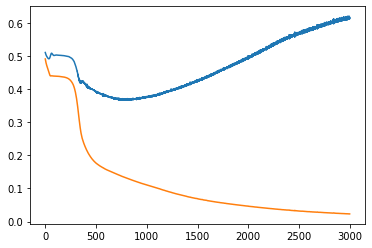

In [13]:
plt.plot(test_loss_record)
plt.plot(train_loss_record)
plt.show()

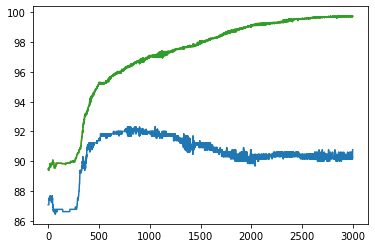

In [14]:
plt.plot(test_acc_record)
plt.plot(train_acc_record)
plt.plot(train_acc_record)
plt.show()

In [15]:
model.eval()

convNet(
  (layer1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(5,), stride=(3,))
    (1): ReLU(inplace=True)
    (2): Conv1d(8, 16, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): ReLU(inplace=True)
    (4): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (5): ReLU(inplace=True)
    (6): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (7): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1344, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [16]:
store_target = pd.DataFrame(columns={'i_set','dataset','train_acc','test_acc','train_loss','test_loss'})

In [17]:
store_target['train_loss'] = train_loss_record
store_target['test_loss'] = test_loss_record
store_target['train_acc'] = train_acc_record
store_target['test_acc'] = test_acc_record
store_target['i_set'] = i_set
store_target['dataset'] = datasetname

In [18]:
test_acc_record.max()

92.30769348144531

In [19]:
path = './mem-1000pre/' + datasetname +'/' + str(i_set) + '_record.csv'
store_target.to_csv(path, index=False)

In [20]:
store_target

,i_set,test_acc,dataset,train_acc,test_loss,train_loss
0,4,87.076920,detailed-1000pre,89.480522,0.510563,0.490969
1,4,87.076920,detailed-1000pre,89.480522,0.509353,0.489071
2,4,87.076920,detailed-1000pre,89.448051,0.508246,0.487284
3,4,87.076920,detailed-1000pre,89.383118,0.507224,0.485630
4,4,87.076920,detailed-1000pre,89.383118,0.506250,0.484093
...,...,...,...,...,...,...
2995,4,90.307693,detailed-1000pre,99.740257,0.611047,0.023508
2996,4,90.307693,detailed-1000pre,99.707794,0.618448,0.023438
2997,4,90.153847,detailed-1000pre,99.740257,0.612156,0.023377
2998,4,90.307693,detailed-1000pre,99.740257,0.617251,0.023314
